In [1]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')

Create data frame of annotation info

In [3]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)

annot_features_full.head()

(959, 13)
Int64Index([], dtype='int64')


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,527,cagepair,18922.5,high slug,44921.600,0.335974,40617.050954,117729.192000,6.831866,48.160918,0.000787,38586.198407
1,1,527,cagepair,24750.0,low slug,53212.637,0.295599,27042.548508,3827.200195,3.556462,20.402396,-0.000227,25690.421083
2,2,527,cagepair,56002.5,bbc,94253.766,0.189555,30090.095178,68103.292456,3.982554,18.393372,-0.002314,28585.590419
3,3,527,cagepair,174352.5,bbc,51008.836,0.306177,34324.170621,52563.703613,3.336529,10.448164,-0.001250,32607.962090
4,4,527,cagepair,342877.5,bbc,164846.110,0.144833,33090.921412,22861.514782,1.852232,3.185318,-0.001784,31436.375341


In [4]:
annot_features_full.groupby('Annotation').describe()

Unnamed: 0                                                             animal_number                                                             time_stamp                                                                                     power_sum                                                                                               spec_pur                                                                       spec_cent                                                                                                   spec_spread                                                                                                        spec_skew                                                                       spec_kurt                                                                              spec_slope                                                                       spec_roll                                                                        \
                count        mean         std   min     25%    50%     75%    max         count        mean        std    min     25%    50%     75%    max      count           mean            std      min         25%        50%         75%       max     count           mean            std        min          25%          50%           75%          max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max       count           mean            std           min           25%            50%            75%            max     count      mean       std       min       25%       50%       75%       max     count       mean        std        min        25%        50%        75%        max      count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%   
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
bbc              45.0   94.533333   55.230756   2.0   37.00  110.0  145.00  157.0          45.0  547.022222  12.083966  527.0  535.00  554.0  557.00  559.0       45.0  203221.000000  163944.266043  13590.0   60570.000  174352.50  276277.500  591255.0      45.0  187049.752200  163252.249644  51008.836  108528.2660  142034.1900  185542.44000    872012.60     45.0  0.135980  0.063951  0.026119  0.091080  0.126480  0.173507  0.306177      45.0  32096.112594   3592.063646  25317.517312  30090.095178  31762.963636  34324.170621  41218.670832        45.0  106052.164971   57973.683260  22861.514782  68103.292456   95060.654641  149716.189200  272975.403907      45.0  3.616554  1.064733  1.420153  3.056477  3.603695  4.080782  5.614859      45.0  14.507654   8.570242   1.158310  10.448164  13.066885  18.996466  34.298438       45.0 -0.002336  0.000402 -0.002793 -0.002664 -0.002428 -0.002093 -0.001040      45.0  30491.306964   3412.460464  24051.641447  28585.590419  30174.815454   
high multi        4.0   89.500000   51.045731  23.0   62.75

In [5]:
orig_maj = annot_features_full[annot_features_full['Annotation'] == 'rand_noise']
orig_min = annot_features_full[annot_features_full['Annotation'] != 'rand_noise']

orig_min_upsamples = resample(orig_min, replace=True, n_samples = len(orig_maj), random_state = 123)

orig_upsamples = pd.concat([orig_min_upsamples, orig_maj])

print(orig_upsamples.Annotation.value_counts())

orig_upsamples.head()

rand_noise    800
low slug      306
bbc           245
high slug     126
low multi     106
high multi     17
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
109,109,554,CPApair,194917.5,bbc,169526.390,0.087578,30706.674848,148978.736880,3.767604,13.329037,-0.002770,29171.341105
126,126,556,cagepair,41670.0,bbc,149727.170,0.165668,41218.670832,47872.106705,3.234582,12.046239,-0.001040,39157.737290
66,66,535,CPApair,442507.5,low slug,29249.727,0.405450,33752.490637,7771.129294,2.825502,14.031428,-0.000010,32064.866105
98,98,552,cagepair,304807.5,bbc,108974.290,0.167719,37420.803536,86972.189224,2.883743,8.330300,-0.002247,35549.763359
17,17,533,CPApair,243157.5,low slug,270193.530,0.062226,11483.575333,37201.715521,6.940257,50.135018,-0.001537,10909.396566


In [6]:
annot_labels_up = orig_upsamples['Annotation']
annot_labels_up = annot_labels_up.replace(regex={r'low slug': 1, 'high slug': 1, 'low multi': 1, 'high multi': 1, 'bbc': 1, 'rand_noise': 0})
orig_upsamples['Label'] = annot_labels_up
orig_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,Label
109,109,554,CPApair,194917.5,bbc,169526.390,0.087578,30706.674848,148978.736880,3.767604,13.329037,-0.002770,29171.341105,1
126,126,556,cagepair,41670.0,bbc,149727.170,0.165668,41218.670832,47872.106705,3.234582,12.046239,-0.001040,39157.737290,1
66,66,535,CPApair,442507.5,low slug,29249.727,0.405450,33752.490637,7771.129294,2.825502,14.031428,-0.000010,32064.866105,1
98,98,552,cagepair,304807.5,bbc,108974.290,0.167719,37420.803536,86972.189224,2.883743,8.330300,-0.002247,35549.763359,1
17,17,533,CPApair,243157.5,low slug,270193.530,0.062226,11483.575333,37201.715521,6.940257,50.135018,-0.001537,10909.396566,1


In [7]:
annot_features_up = orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]

In [8]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

[0.3700116747949144, 0.3738315296388018, 0.37784374764404355, 0.3923384220271772, 0.3974062506820386, 0.4036444498648835, 0.4012618864173746, 0.3999191532406923, 0.4006948478184751, 0.4001114617553948, 0.403650554413215, 0.40510812764240967, 0.3950851813929909, 0.4030042674424822, 0.3930941438397486, 0.34955915339491783, 0.3744098362826287, 0.39404466330063914, 0.3533282901583631, 0.38546835948554575, 0.3907863191877929, 0.3473602016677458, 0.35962041423716296, 0.34300571432677207, 0.3698248412358734, 0.3601807282136471, 0.3618481983932865, 0.34239776143847606]


Text(0, 0.5, 'Silhouette Coefficient')

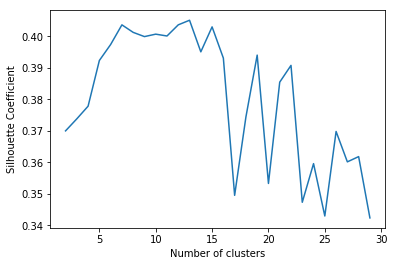

In [9]:
k_range = range(2,30)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=19)
    km_ss.fit(features_scaled)
    scores.append(silhouette_score(features_scaled, km_ss.labels_))

print(scores)

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [10]:
km7 = KMeans(n_clusters=7,random_state=19)
km7.fit(features_scaled)
score = silhouette_score(features_scaled, km7.labels_)
orig_upsamples['kmeans_7_scaled'] = [ "cluster_" + str(label) for label in km7.labels_ ]
print(score)

0.4036444498648835


In [11]:
orig_upsamples.groupby('Annotation')['kmeans_7_scaled'].value_counts()

Annotation  kmeans_7_scaled
bbc         cluster_6          231
            cluster_0           14
high multi  cluster_4           12
            cluster_6            5
high slug   cluster_4           40
            cluster_6           23
            cluster_2           21
            cluster_0           20
            cluster_3           20
            cluster_1            2
low multi   cluster_2           93
            cluster_6            6
            cluster_0            4
            cluster_4            3
low slug    cluster_2          144
            cluster_4           74
            cluster_0           60
            cluster_6           20
            cluster_1            8
rand_noise  cluster_0          443
            cluster_1          159
            cluster_4          110
            cluster_2           80
            cluster_6            7
            cluster_5            1
Name: kmeans_7_scaled, dtype: int64

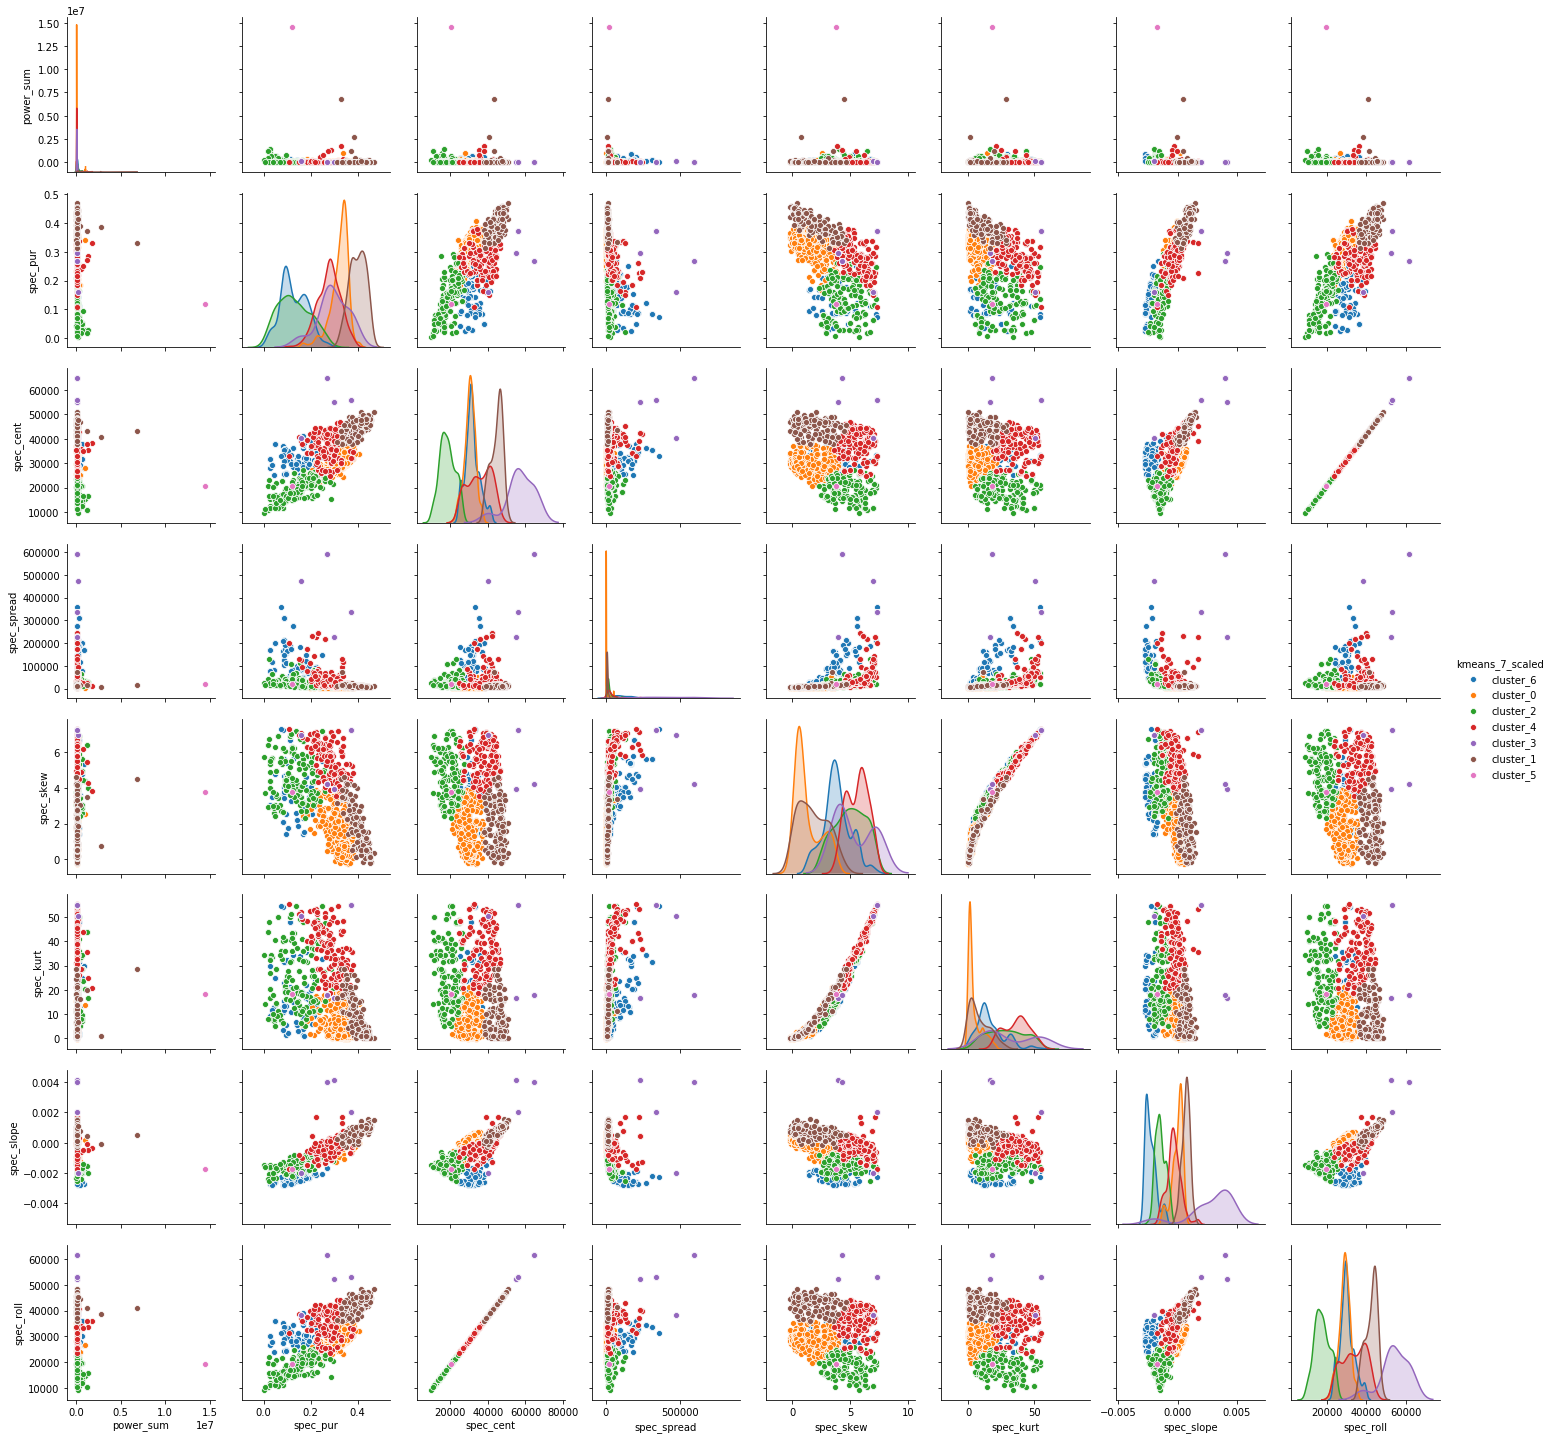

In [12]:
sns.pairplot(orig_upsamples, vars=['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll'], hue="kmeans_7_scaled")

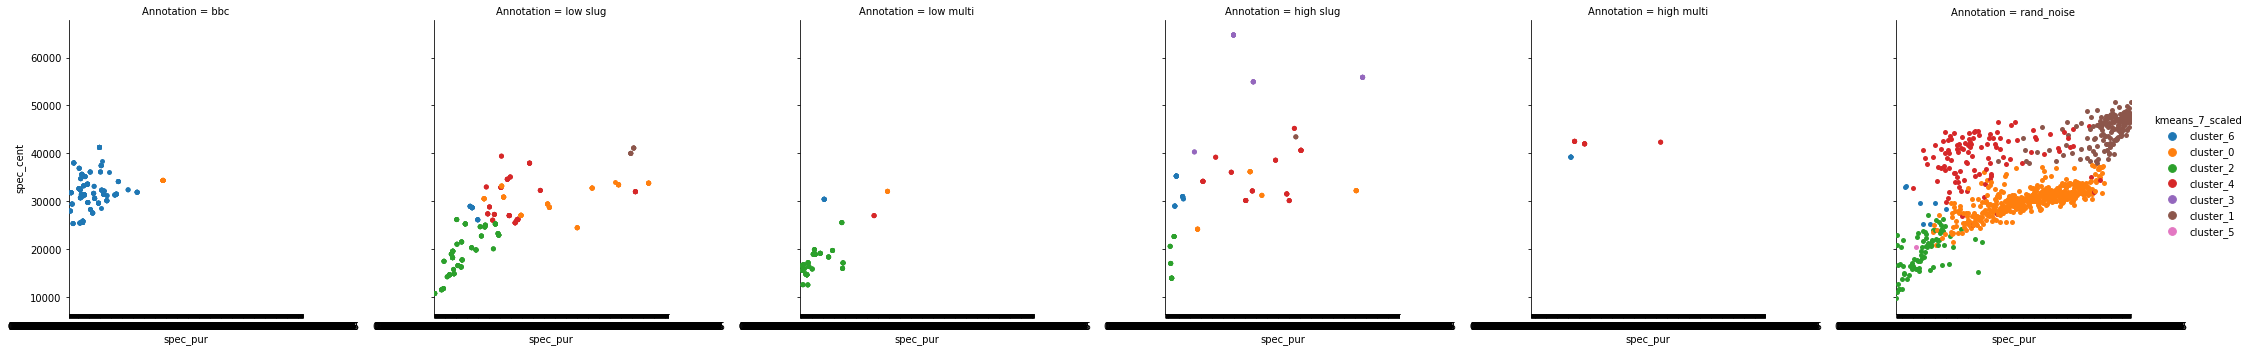

In [13]:
sns.catplot(x="spec_pur", y="spec_cent", hue="kmeans_7_scaled", col='Annotation', data=orig_upsamples)

In [ ]:
orig_upsamples.head()

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8, whiten=True)
pca_features = pca.fit_transform(features_scaled)

In [15]:
print(features_scaled.shape)
print(pca_features.shape)
print(pca.components_.shape)
pca_features[0]

(1600, 8)
(1600, 8)
(8, 8)


array([ 0.88447688,  0.4640141 ,  1.13350678, -1.88002793, -0.53896633,
       -0.44420148, -0.29245005, -2.80356472])

In [16]:
orig_upsamples.columns.values

array(['Unnamed: 0', 'animal_number', 'session', 'time_stamp',
       'Annotation', 'power_sum', 'spec_pur', 'spec_cent', 'spec_spread',
       'spec_skew', 'spec_kurt', 'spec_slope', 'spec_roll', 'Label',
       'kmeans_7_scaled'], dtype=object)

Text(0, 0.5, 'Component')

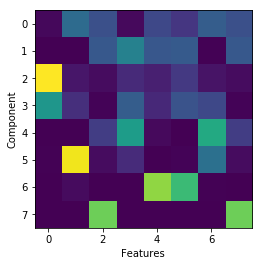

In [17]:
plt.imshow(pca.components_**2)
plt.xlabel('Features')
plt.ylabel('Component')

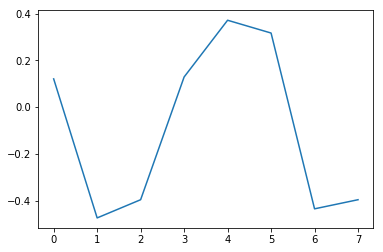

In [18]:
plt.plot(pca.components_[0, :])

In [27]:
pca_df = pd.DataFrame(data = pca_features, columns = ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7'], index = orig_upsamples['Unnamed: 0'])
pca_df['label'] = orig_upsamples['Label'].values
pca_df['annotation'] = orig_upsamples['Annotation'].values
print(pca_df.shape)
print(pca_df.annotation.value_counts())
pca_df.head()

(1600, 10)
rand_noise    800
low slug      306
bbc           245
high slug     126
low multi     106
high multi     17
Name: annotation, dtype: int64


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,label,annotation
Unnamed: 0,,,,,,,,,,
109,0.884477,0.464014,1.133507,-1.880028,-0.538966,-0.444201,-0.292450,-2.803565,1,bbc
126,-0.277669,0.587418,0.721192,-0.714002,-1.726931,2.317788,-0.036832,10.704487,1,bbc
66,-0.738435,-0.104058,-0.476430,0.534847,-0.139707,-1.821741,-1.224291,-3.245673,1,low slug
98,0.089574,0.379195,0.977892,-1.528763,-1.723859,-0.064839,-0.067235,-0.984930,1,bbc
17,2.183321,-0.199672,-1.001653,1.157412,1.087692,0.769774,1.584564,-0.397223,1,low slug


Text(0.5, 1.0, 'Singular values')

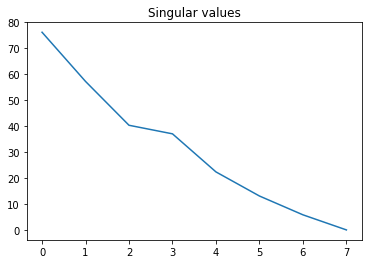

In [20]:
plt.plot(pca.singular_values_)
plt.title("Singular values")

Text(0.5, 1.0, 'Projection of the data on 2 components + ground truth labels')

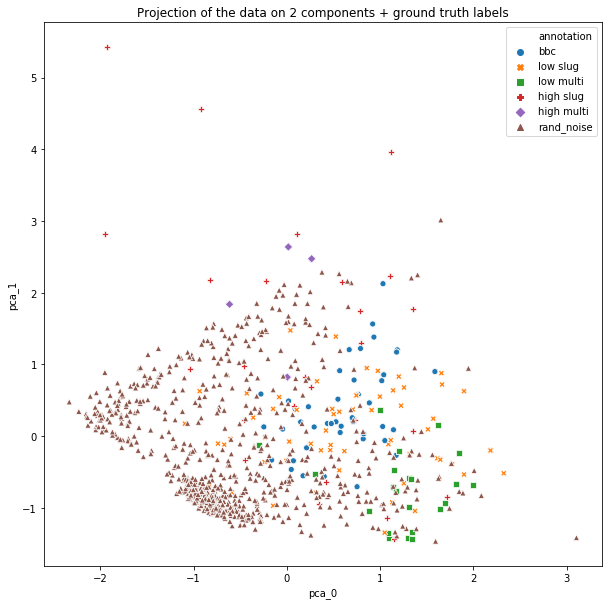

In [21]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'pca_0', y = 'pca_1', hue = 'annotation', data = pca_df, style = 'annotation')
plt.title("Projection of the data on 2 components + ground truth labels")

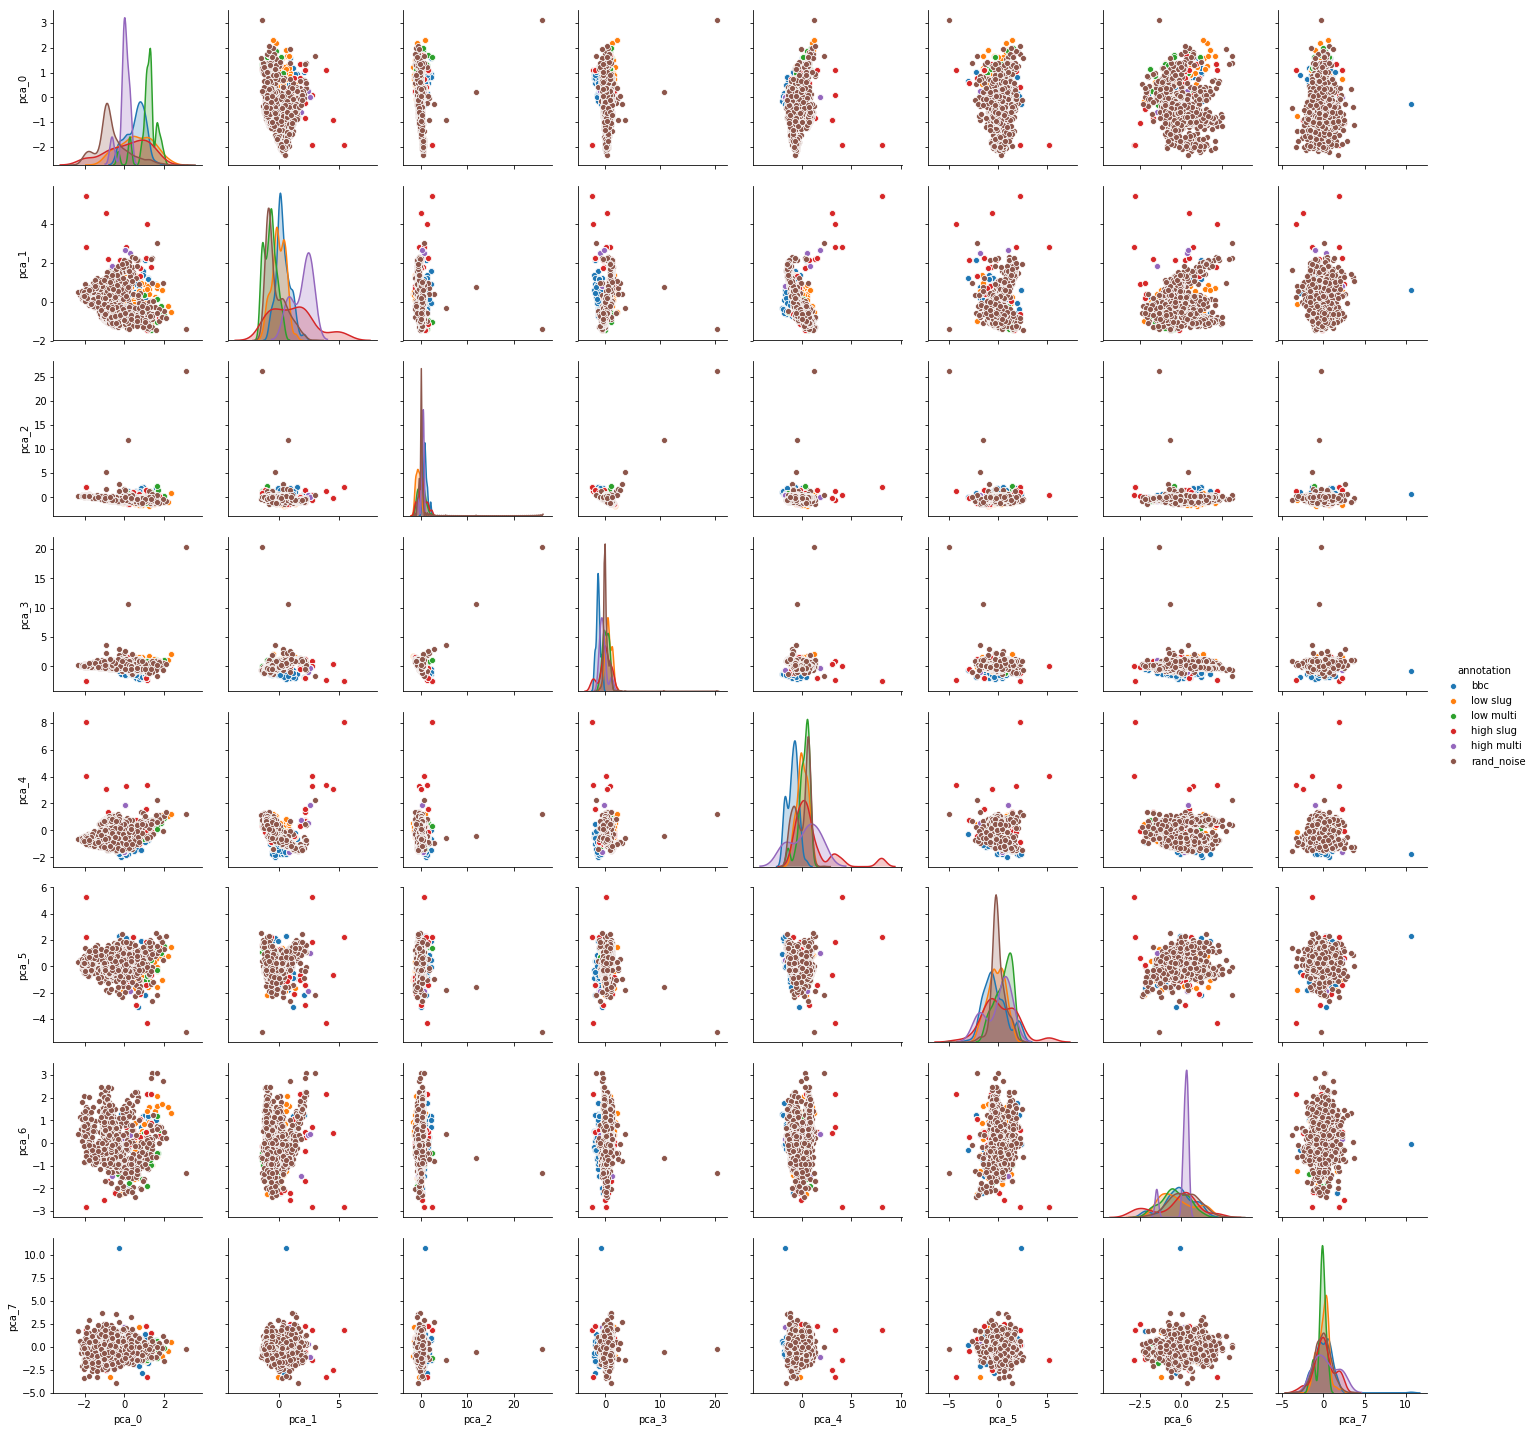

In [22]:
sns.pairplot(pca_df, vars=['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6',
       'pca_7'], hue="annotation")

In [28]:
%%time
# This function takes long to run, we will apply it to the first 10000 observations
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_features = tsne.fit_transform(features_scaled)

Wall time: 17.7 s


In [29]:
print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = orig_upsamples['Unnamed: 0'])
tsne_df['label'] = orig_upsamples['Label'].values
tsne_df['annotation'] = orig_upsamples['Annotation'].values
tsne_df.head()

(1600, 2)


,tsne_0,tsne_1,label,annotation
Unnamed: 0,,,,
109,40.907810,-37.879662,1,bbc
126,10.498457,-41.865902,1,bbc
66,2.824060,16.510540,1,low slug
98,18.624554,-43.383533,1,bbc
17,-36.128101,-32.844593,1,low slug


Text(0.5, 1.0, 'Projection of the data on 2 components + ground truth labels')

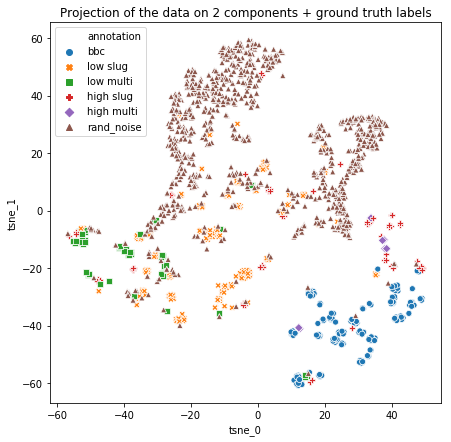

In [30]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'tsne_0', y = 'tsne_1', hue = 'annotation', data = tsne_df, style = 'annotation')
plt.title("Projection of the data on 2 components + ground truth labels")

In [32]:
specs = []
for index, row in orig_upsamples.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['animal_number']) + '_xr_Dataset.nc')
    
    xr_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp']).values
    
    times = data['times'].values
    freqs = data['freq'].values
    
    specs.append(xr_slice)
    
X = np.stack(specs)
y = annot_labels_up.values
print(X.shape)
print(y.shape)

(1600, 257, 55)
(1600,)


In [34]:
# The code below visualizes the data projected in 2D together with the original spectrograms

from matplotlib import offsetbox
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
# Scale and visualize the embedding vectors
def plot_embedding(X, X_embedded, title=None):
    x_min, x_max = np.min(X_embedded, 0), np.max(X_embedded, 0)
    X_embedded = (X_embedded - x_min) / (x_max - x_min)

    plt.figure(figsize = (10,10))
    ax = plt.subplot(111)
    for i in range(X_embedded.shape[0]):
        plt.text(X_embedded[i, 0], X_embedded[i, 1], 'o',
                 color=plt.cm.viridis(y[i] / 0.01),
                 #color=colors[i],
                 #color=int(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X_embedded.shape[0]):
            dist = np.sum((X_embedded[i,:] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X_embedded[i,:]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.flipud(np.log(X[i,:])),zoom = 0.3, cmap='plasma'),
                X_embedded[i,:])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

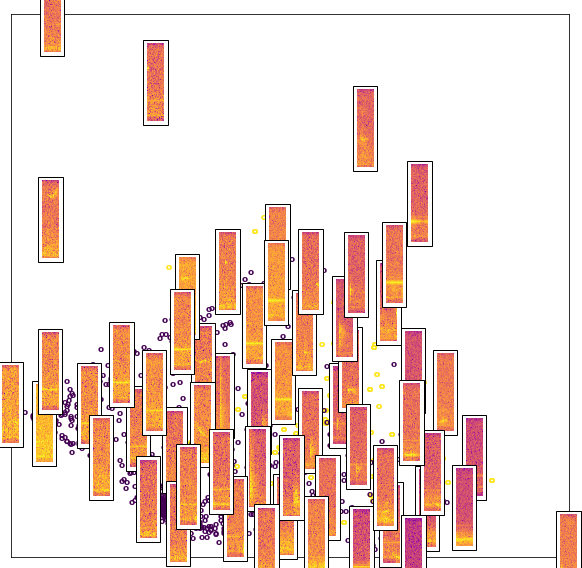

In [35]:
plot_embedding(X, pca_features[:,:2])

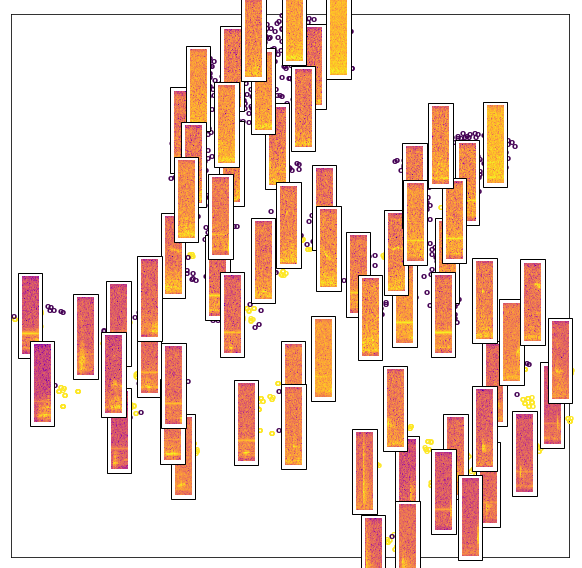

In [36]:
plot_embedding(X, tsne_features[:,:2])